#Node2Vec

In [2]:
import os

print(os.getcwd())

/home/arumota_pupils/Josue/Node2Vec/Challenge-Reproducibilidad


In [4]:
import networkx as nx

# Cargar el grafo desde el archivo
G = nx.read_weighted_edgelist('moreno_lesmis/out.moreno_lesmis_lesmis', 
                     comments='%',
                     create_using=nx.Graph())

# Cantidad de nodos y aristas en el grafo
print(f"Número de nodos: {G.number_of_nodes()}")
print(f"Número de aristas: {G.number_of_edges()}")

# Ver un resumen del grafo
print("Nodos:", list(G.nodes))    
print("Aristas:", list(G.edges))  

Número de nodos: 77
Número de aristas: 254
Nodos: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '24', '25', '26', '27', '28', '29', '30', '32', '33', '34', '35', '36', '37', '38', '39', '44', '45', '49', '50', '52', '56', '59', '65', '69', '70', '71', '72', '73', '17', '18', '19', '20', '21', '22', '23', '31', '42', '43', '51', '40', '41', '76', '55', '46', '53', '58', '63', '47', '48', '60', '61', '62', '64', '66', '67', '74', '75', '77', '57', '54', '68']
Aristas: [('1', '2'), ('2', '3'), ('2', '4'), ('2', '5'), ('2', '6'), ('2', '7'), ('2', '8'), ('2', '9'), ('2', '10'), ('2', '11'), ('3', '4'), ('3', '11'), ('4', '11'), ('11', '12'), ('11', '13'), ('11', '14'), ('11', '15'), ('11', '16'), ('11', '24'), ('11', '25'), ('11', '26'), ('11', '27'), ('11', '28'), ('11', '29'), ('11', '30'), ('11', '32'), ('11', '33'), ('11', '34'), ('11', '35'), ('11', '36'), ('11', '37'), ('11', '38'), ('11', '39'), ('11', '44'), ('11', '45'), ('11', '49'), ('11

In [ ]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


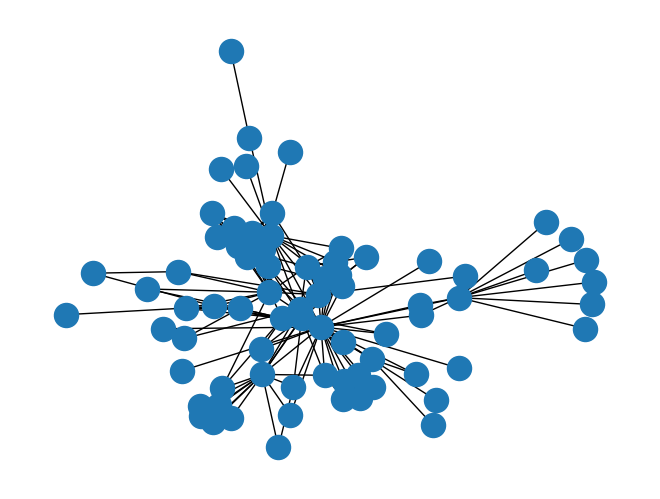

In [6]:
import matplotlib
nx.draw(G)

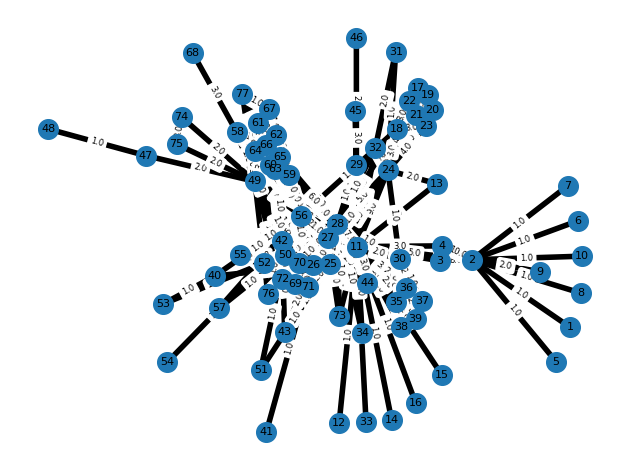

In [7]:
# Visualizemos el grafo con sus pesos
import matplotlib.pyplot as plt

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.5]

pos = nx.spring_layout(G, seed=10)

# nodes
nx.draw_networkx_nodes(G, pos, node_size=200)

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=4)
nx.draw_networkx_edges(
    G, pos, edgelist=esmall, width=4, alpha=0.5, edge_color="b", style="dashed"
)

# node labels
nx.draw_networkx_labels(G, pos, font_size=8, font_family="sans-serif")
# edge weight labels
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=6)

ax = plt.gca()
ax.margins(0.02)
plt.axis("off")
plt.tight_layout()
plt.show()

In [8]:
#Implementacion del First Order Random Walk
def random_walk_FO(graph, start_node, walk_length):
    import random
    walk = [start_node]
    current_node = start_node
    
    for _ in range(walk_length):
        neighbors = [n for n in G.neighbors(current_node)] #Listamos todos los vecinos del nodo
        if not neighbors:
            break

        total_weight = 0
        individual_weights = []
        for i in neighbors:
            total_weight = total_weight + G.get_edge_data(current_node,i)['weight'] #Calculamos la suma de los pesos de los vecinos
            individual_weights.append(G.get_edge_data(current_node,i)['weight']) #Guardamos los pesos de cada arista en una lista

        probs = [w / total_weight for w in individual_weights] #Normalizamos las probabilidades

        current_node = random.choices(neighbors,weights=probs, k=1)[0] #Hacemos la decisión random, pero teniendo en cuenta las probabilidades
        walk.append(current_node)
    
    return walk

In [9]:
walk = random_walk_FO(G,"2",10)
print(walk)

['2', '4', '2', '4', '3', '2', '10', '2', '3', '4', '3']


# Josué

In [10]:
# ===== 0.1  Imports =====
import networkx as nx
import numpy as np
import random
from collections import defaultdict
from tqdm import tqdm
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ===== 0.2  Determinism =====
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# ===== 0.3  Load or build graph =====
# Example: Les Misérables from NetworkX
G = nx.les_miserables_graph()             # weighted, undirected
print(f"Graph: |V|={G.number_of_nodes()}  |E|={G.number_of_edges()}")


Graph: |V|=77  |E|=254


In [11]:
def alias_setup(probs):
    """
    Convert a probability list into alias tables (J, q) for O(1) sampling.
    returns: (J, q) both length K
    """
    K = len(probs)
    q = np.zeros(K)
    J = np.zeros(K, dtype=np.int32)

    # Worklists
    smaller, larger = [], []
    for idx, p in enumerate(probs):
        q[idx] = K * p
        (smaller if q[idx] < 1.0 else larger).append(idx)

    # Populate J, q
    while smaller and larger:
        s = smaller.pop()
        l = larger.pop()
        J[s] = l
        q[l] = q[l] - (1.0 - q[s])
        (smaller if q[l] < 1.0 else larger).append(l)

    return J, q

def alias_draw(J, q):
    """
    Draw a single sample from alias tables.
    """
    K = len(J)
    kk = int(np.floor(np.random.rand() * K))
    return kk if np.random.rand() < q[kk] else J[kk]


In [12]:
class Node2VecWalker:
    def __init__(self, graph, p=1.0, q=1.0, directed=False):
        self.G = graph
        self.p = p
        self.q = q
        self.directed = directed
        self._preprocess_transition_probs()

    # ---------- public ----------
    def simulate_walks(self, num_walks, walk_len, verbose=True):
        walks = []
        nodes = list(self.G.nodes())
        for _ in range(num_walks):
            random.shuffle(nodes)
            for node in tqdm(nodes, disable=not verbose):
                walks.append(self._walk(walk_len, start=node))
        return walks

    # ---------- internal ----------
    def _walk(self, length, start):
        walk = [start]
        while len(walk) < length:
            curr = walk[-1]
            neighbors = sorted(self.G.neighbors(curr))
            if len(neighbors) == 0:
                break

            if len(walk) == 1:
                # first step: simple weighted choice
                next_node = neighbors[alias_draw(*self.alias_nodes[curr])]
            else:
                prev = walk[-2]
                edge_key = (prev, curr) if self.directed else (prev, curr) \
                           if (prev, curr) in self.alias_edges else (curr, prev)
                next_node = neighbors[alias_draw(*self.alias_edges[edge_key])]
            walk.append(next_node)
        return [str(n) for n in walk]          # gensim expects str tokens

    # Pre-compute alias tables -----------------------------------------------
    def _get_edge_alias(self, src, dst):
        """
        Transition probs conditioned on (src=prev, dst=curr),
        equations (2) and (3) of the paper
        """
        probs = []
        for dst_nbr in sorted(self.G.neighbors(dst)):
            weight = self.G[dst][dst_nbr].get('weight', 1.0)
            if dst_nbr == src:            # distance = 0
                bias = 1 / self.p
            elif self.G.has_edge(dst_nbr, src):
                bias = 1                  # distance = 1
            else:
                bias = 1 / self.q         # distance = 2
            probs.append(weight * bias)
        norm = sum(probs)
        probs = [p / norm for p in probs]
        return alias_setup(probs)

    def _preprocess_transition_probs(self):
        # Alias for 1-hop neighbors (first step)
        self.alias_nodes = {}
        for node in self.G.nodes():
            probs = [self.G[node][nbr].get('weight', 1.0)
                     for nbr in sorted(self.G.neighbors(node))]
            norm = sum(probs)
            probs = [p / norm for p in probs]
            self.alias_nodes[node] = alias_setup(probs)

        # Alias for conditional edges (second-order)
        self.alias_edges = {}
        for edge in self.G.edges():
            self.alias_edges[edge] = self._get_edge_alias(edge[0], edge[1])
            if not self.directed:
                self.alias_edges[(edge[1], edge[0])] = self._get_edge_alias(edge[1], edge[0])


In [24]:
# Hyper-parameters (paper defaults are p=q=1; tweak to explore)
WALK_LENGTH  = 30
NUM_WALKS    = 200
P, Q         = 1, 0.5          # BFS ↔ DFS balance

walker = Node2VecWalker(G, p=P, q=Q, directed=False)
walks  = walker.simulate_walks(NUM_WALKS, WALK_LENGTH)
print(f"Generated {len(walks)} walks – e.g. {walks[0][:10]} …")

100%|██████████| 77/77 [00:00<00:00, 9166.19it/s]


100%|██████████| 77/77 [00:00<00:00, 9035.15it/s]


Generated 15400 walks – e.g. ['Woman1', 'Valjean', 'Fauchelevent', 'Valjean', 'Cochepaille', 'Valjean', 'Enjolras', 'Combeferre', 'Courfeyrac', 'Combeferre'] …


In [28]:
walks = walker.simulate_walks(NUM_WALKS, WALK_LENGTH)
nodes = list(G.nodes())
from torch_spikgram import train_skipgram

emb_dict = train_skipgram(
    walks,
    node_list=nodes,
    emb_dim=64,
    window=10,
    neg_samples=5,
    epochs=1,
    lr=0.025,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)


100%|██████████| 77/77 [00:00<00:00, 7947.08it/s]


KeyboardInterrupt: 

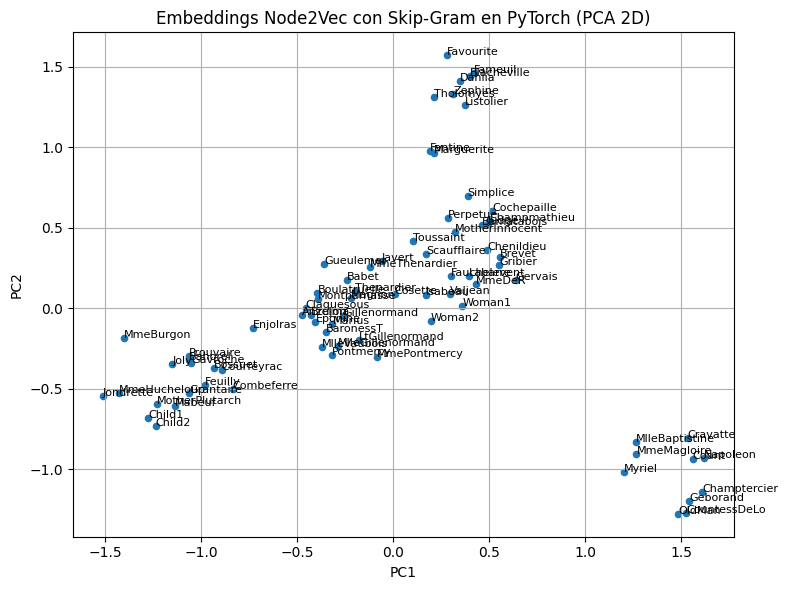

In [29]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Convertir los vectores a una matriz numpy (ordenada por nodos del grafo)
vectors = np.array([emb_dict[str(n)] for n in G.nodes()])
labels = list(G.nodes())

# 2. Reducción a 2D con PCA
pca = PCA(n_components=2, random_state=SEED)
proj = pca.fit_transform(vectors)

# 3. Graficar
plt.figure(figsize=(8, 6))
plt.scatter(proj[:, 0], proj[:, 1], s=20)

# Añadir etiquetas a cada punto
for i, label in enumerate(labels):
    plt.text(proj[i, 0], proj[i, 1], str(label), fontsize=8)

plt.title("Embeddings Node2Vec con Skip-Gram en PyTorch (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()


In [30]:
from sklearn.metrics.pairwise import cosine_similarity

def most_similar(target_node, topk=5):
    target_vec = emb_dict[str(target_node)].reshape(1, -1)
    all_nodes = list(G.nodes())
    all_vecs = np.array([emb_dict[str(n)] for n in all_nodes])
    
    sims = cosine_similarity(target_vec, all_vecs).flatten()
    top_indices = sims.argsort()[::-1][1:topk+1]  # [1:] para excluir el propio nodo
    return [(all_nodes[i], sims[i]) for i in top_indices]

# Ejemplo:
print("Vecinos más similares a 'Valjean':")
for node, sim in most_similar('Valjean'):
    print(f"{node:10s} → similitud: {sim:.3f}")

Vecinos más similares a 'Valjean':
MotherInnocent → similitud: 0.624
Champmathieu → similitud: 0.616
MlleBaptistine → similitud: 0.606
Cosette    → similitud: 0.604
Gribier    → similitud: 0.586
